In [1]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Định nghĩa thư mục lưu trữ dữ liệu
data_dir = "data"
csv_filename = "CSCO.csv"
csv_filepath = os.path.join(data_dir, csv_filename)

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Kiểm tra xem tệp đã tồn tại trong thư mục hiện tại hay chưa
if os.path.exists(csv_filepath):
    csco = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
else:
    ticker = "CSCO" # Mã chứng khoán
    start_date = "2024-01-01" # Ngày bắt đầu
    end_date = "2024-04-30" # Ngày kết thúc
    csco = yf.download(ticker, start=start_date, end=end_date)
    if not csco.empty:
        csco.to_csv(csv_filepath)
    else:
        raise ValueError("Không có dữ liệu để tải về. Kiểm tra lại mã chứng khoán và thời gian dữ liệu")

In [3]:
# Dự báo bằng phương pháp Exponential Smoothing cho từng cột
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
forecast_index = pd.date_range(start=csco.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

In [4]:
# Hàm đánh giá mô hình
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [5]:
# Số lượng dữ liệu dùng để đánh giá
validation_steps = 30

# Thu thập kết quả dự đoán và đánh giá
forecast_results = []
evaluation_results = []

for column in columns:
    data = csco[column].values

    # Dự báo bằng phương pháp làm Exponential Smoothing (mịn hàm mũ)
    model_es = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
    fit_es = model_es.fit()
    forecast_es = fit_es.forecast(steps=validation_steps)

    # Đảm bảo dữ liệu thực tế có đủ số lượng để đánh giá
    actual_values = csco[column].values[-validation_steps:]
    if len(actual_values) < validation_steps:
        continue

    # Đánh giá mô hình trên dữ liệu thực tế
    mae, mse, rmse = evaluate_forecast(actual_values, forecast_es)

    # Thu thập kết quả dự đoán và đánh giá
    forecast_results.append(f"Giá trị {column} dự đoán ngày {forecast_index[0].date()} = {forecast_es[0]:.2f} (ES)")
    evaluation_results.append(f"Đánh giá mô hình {column} (ES): MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# In kết quả dự đoán và đánh giá mô hình
print("\nDự đoán cho ngày tiếp theo")
for result in forecast_results:
    print(f"     {result}")
print("\n" + "-"*80)
print("\nĐánh giá mô hình Exponential Smoothing ")
for result in evaluation_results:
    print(f"     {result}")
    


Dự đoán cho ngày tiếp theo
     Giá trị Open dự đoán ngày 2022-07-13 = 43.51 (ES)
     Giá trị High dự đoán ngày 2022-07-13 = 43.80 (ES)
     Giá trị Low dự đoán ngày 2022-07-13 = 42.61 (ES)
     Giá trị Close dự đoán ngày 2022-07-13 = 42.87 (ES)
     Giá trị Volume dự đoán ngày 2022-07-13 = 19475127.37 (ES)

--------------------------------------------------------------------------------

Đánh giá mô hình Exponential Smoothing 
     Đánh giá mô hình Open (ES): MAE: 0.91, MSE: 1.16, RMSE: 1.08
     Đánh giá mô hình High (ES): MAE: 0.84, MSE: 1.09, RMSE: 1.04
     Đánh giá mô hình Low (ES): MAE: 0.86, MSE: 1.31, RMSE: 1.14
     Đánh giá mô hình Close (ES): MAE: 0.87, MSE: 1.35, RMSE: 1.16
     Đánh giá mô hình Volume (ES): MAE: 7972856.32, MSE: 179177088034523.81, RMSE: 13385704.61


e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Số lượng phần tử trong forecast_es: 30
Số lượng phần tử trong forecast_index: 30


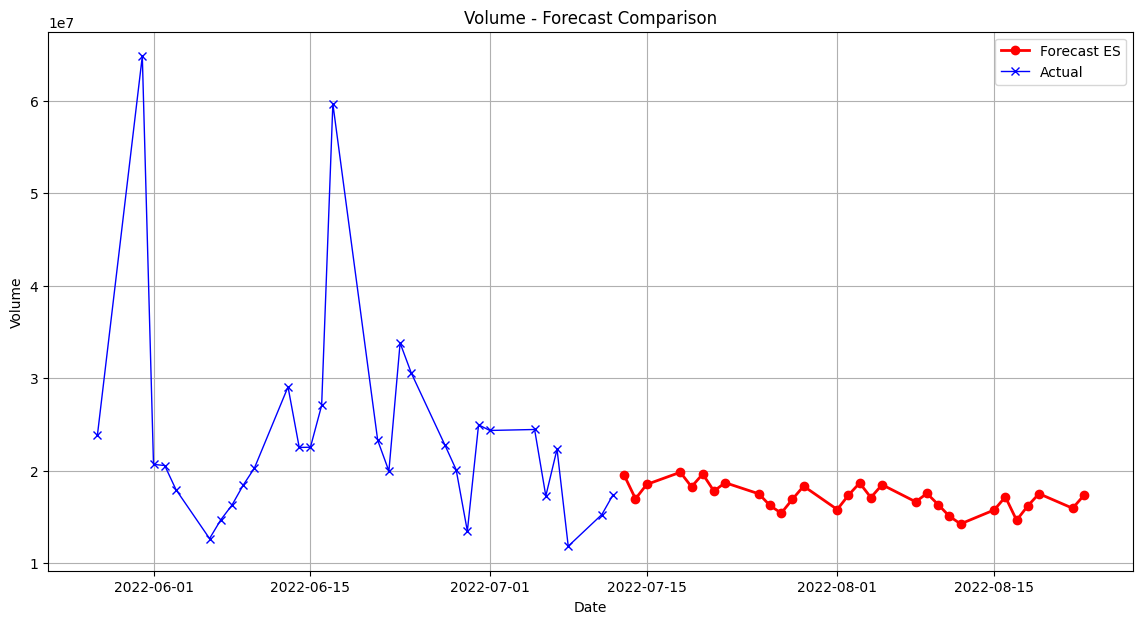

In [6]:
import matplotlib.pyplot as plt
# In số lượng phần tử trong forecast_es và forecast_index
print("Số lượng phần tử trong forecast_es:", len(forecast_es))
print("Số lượng phần tử trong forecast_index:", len(forecast_index))
# Số lượng forecast_index và forecast_es sau khi đếm là 30 phần tử
# Lấy 30 phần tử cuối cùng của dữ liệu thực tế
actual_index = csco.index[-30:]
actual_values = csco[column][-30:]
plt.figure(figsize=(14, 7))
# Vẽ giá trị dự báo Exponential Smoothing
plt.plot(forecast_index, forecast_es, label='Forecast ES', color='red', linewidth=2, marker='o')
# Vẽ dữ liệu thực tế với 30 phần tử cuối cùng
plt.plot(actual_index, actual_values, label='Actual', color='blue', linewidth=1, marker='x')
plt.title(f'{column} - Forecast Comparison')
plt.xlabel('Date')
plt.ylabel(column)
plt.legend()
plt.grid(True)
plt.show()